In [1]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
sns.set_style("dark")

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas_datareader.data import DataReader
import datetime as dt

# libraries for pipeline|
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA

# Gridsearch
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score

#metrics
import sklearn.metrics as metrics

# Models to try
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

# custom functions
from modules import functions

# Market Data Gathering

In [46]:
# Important dates
start = dt.datetime(2019,8,14)
end = dt.datetime(2022,8,14)


In [47]:
# import data
nflx = DataReader("NFLX",  "yahoo", start, end)
gspc = DataReader("^GSPC", "yahoo", start, end)

In [48]:
# concatenate stock and market data
# features = functions.concatRename(nflx, 'nflx_', pd.DataFrame(gspc['Adj Close']), 'gspc_')

# Set-up time series prediction

Pipelines does not support dropping rows in the target data, so we must pre-process here. We take the features from the previous n days and use them to predict 

In [49]:
# target variable name
nflx_target = 'Adj Close'

# we do not drop the target variable, as we'll be shifting it
X = nflx
y = nflx[nflx_target]

In [50]:
# shift features and drop nans
rolling = 1
X_shifted = functions.shiftTime(X, rolling)

# find diff and drop nans
diff_delta = 1
X_diff = functions.trendDiff(X_shifted,diff_delta)

# put together
X_shifted = functions.concatRename(X_shifted, '', X_diff, 'diff_')
X_shifted.dropna(how='any', inplace=True)

# drop rolling rows from y
y_shifted = y.iloc[rolling+1:]

In [51]:
X_shifted

,High,Low,Open,Close,Volume,Adj Close,diff_High,diff_Low,diff_Open,diff_Close,diff_Volume,diff_Adj Close
Date,,,,,,,,,,,,
2019-08-16,300.630005,288.000000,299.500000,295.760010,9629200.0,295.760010,-7.779999,-10.010010,-8.510010,-3.349976,2273400.0,-3.349976
2019-08-19,303.549988,296.269989,298.859985,302.799988,6905800.0,302.799988,2.919983,8.269989,-0.640015,7.039978,-2723400.0,7.039978
2019-08-20,311.750000,304.750000,306.250000,309.380005,4942200.0,309.380005,8.200012,8.480011,7.390015,6.580017,-1963600.0,6.580017
2019-08-21,305.000000,297.679993,304.570007,298.989990,7349900.0,298.989990,-6.750000,-7.070007,-1.679993,-10.390015,2407700.0,-10.390015
2019-08-22,302.880005,296.200012,301.609985,297.809998,5685400.0,297.809998,-2.119995,-1.479980,-2.960022,-1.179993,-1664500.0,-1.179993
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-08,228.619995,222.869995,225.300003,226.779999,5533200.0,226.779999,-3.450012,-2.180008,-2.379990,-3.130005,-1609500.0,-3.130005
2022-08-09,241.960007,226.410004,227.490005,233.490005,10982100.0,233.490005,13.340012,3.540009,2.190002,6.710007,5448900.0,6.710007
2022-08-10,232.199997,224.649994,231.619995,229.940002,6181200.0,229.940002,-9.760010,-1.760010,4.129990,-3.550003,-4800900.0,-3.550003


In [52]:
# take the last 0.20% for validation
test_size = 0.7

X_train, X_test = functions.testSplit(X_shifted, test_size)
y_train, y_test = functions.testSplit(y_shifted, test_size)

# Pipeline

In [53]:
# # specify feats for column transformer, those not included will be dropped
# num_feats = X_train.columns

# # only differenced columns
# num_feats = [feat for feat in X_train.columns if 'diff' in feat]

# Just important features
num_feats = nflx.columns

In [54]:
# Feature Engineering Pipelines

num_transform = Pipeline([
    ('Imputer', KNNImputer()),
    ('scaling', StandardScaler()),
    # ('PCA', PCA(n_components=2))
    ])

In [55]:
feature_engineering = ColumnTransformer([
    ('num_transform', num_transform, num_feats),
    ], remainder='drop')

In [56]:
pipeline = Pipeline([
    ('feature_engineering', feature_engineering),
    ('regressor', xgb.XGBRegressor()),
    ])

In [57]:
# calculate baseline score
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
functions.regression_results(y_test, y_pred)

explained_variance:  0.856
mean_squared_log_error:  0.0207
r2:  0.856
MAE:  37.8245
MSE:  2612.5368
RMSE:  51.113


<AxesSubplot:xlabel='Date'>

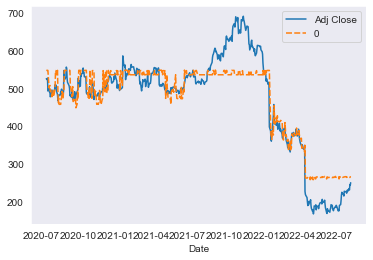

In [58]:
# plot predictions
pred_df = pd.concat([y_test, pd.Series(y_pred, index=y_test.index)], axis=1)
sns.lineplot(data=pred_df)

# Optimization

In [59]:
# model params
model_params = {
    'regressor': [
                LinearRegression(), 
                # MLPRegressor(solver='lbfgs'),
                KNeighborsRegressor(),
                RandomForestRegressor(n_estimators=10),
                SVR(gamma='auto'),
                xgb.XGBRegressor(),
                ]
}

In [82]:
pipeline.steps[0]

('feature_engineering',
 ColumnTransformer(transformers=[('num_transform',
                                  Pipeline(steps=[('Imputer', KNNImputer()),
                                                  ('scaling',
                                                   StandardScaler())]),
                                  Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object'))]))

In [110]:
# XGBoost params
xgb_params = {
    # 'feature_engineering__num_transform_scaling': [MinMaxScaler(), StandardScaler()],
    'regressor__booster': ['gbtree', 'gblinear'],
    'regressor__eta': [0.1, 0.3, 0.5],
    'regressor__min_child_weight': [0.5, 1 , 2],
    'regressor__max_depth': [3, 6, 10],
    'regressor__gamma': [0, 1, 3],
}

In [111]:
# make custome scorer
rmse_score = metrics.make_scorer(functions.rmse, greater_is_better=False)

In [112]:
# instantiate gridsearch and time series CV technique
gridsearch = GridSearchCV(estimator=pipeline, param_grid=xgb_params, cv=TimeSeriesSplit(n_splits=10), scoring=rmse_score)

In [113]:
# find best model
gridsearch.fit(X_train, y_train)
best_model = gridsearch.best_estimator_
best_score = gridsearch.best_score_

[20:07:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:07:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "ma

In [114]:
# calculate baseline score
y_pred = best_model.predict(X_test)
functions.regression_results(y_test, y_pred)

explained_variance:  0.967
mean_squared_log_error:  0.0053
r2:  0.9522
MAE:  25.6944
MSE:  867.4775
RMSE:  29.453


<AxesSubplot:xlabel='Date'>

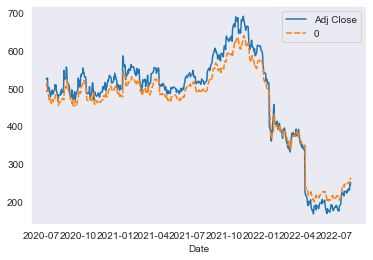

In [115]:
# plot predictions
pred_df = pd.concat([y_test, pd.Series(y_pred, index=y_test.index)], axis=1)
sns.lineplot(data=pred_df)

In [106]:
gridsearch.best_score_

-17.089817299809724

In [98]:
best_model.steps[1][1].coef_.shape

NameError: name 'best_model' is not defined